In [ ]:
!pip install tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 86.3MB 40kB/s 
     |████████████████████████████████| 3.8MB 40.1MB/s 
     |████████████████████████████████| 450kB 49.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=c969cbf3cbbf3479d1fe1504569e47c2ae6ed5650b6d1b11c0c38378de97b32d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation

In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras_preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.layers import Activation, Dropout, Flatten, Dense
import time
print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-05-11 19:17:34--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   164MB/s    in 0.4s    

2020-05-11 19:17:34 (164 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rotation_range=40,
        rescale=1./255,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
100/100 - 17s - loss: 0.7601 - acc: 0.5475 - val_loss: 0.6578 - val_acc: 0.6630
Epoch 2/15
100/100 - 17s - loss: 0.6472 - acc: 0.6355 - val_loss: 0.6358 - val_acc: 0.6540
Epoch 3/15
100/100 - 17s - loss: 0.6209 - acc: 0.6695 - val_loss: 0.5773 - val_acc: 0.6890
Epoch 4/15
100/100 - 17s - loss: 0.6000 - acc: 0.6870 - val_loss: 0.6716 - val_acc: 0.6260
Epoch 5/15
100/100 - 17s - loss: 0.5888 - acc: 0.6995 - val_loss: 0.6114 - val_acc: 0.6770
Epoch 6/15
100/100 - 17s - loss: 0.5570 - acc: 0.7245 - val_loss: 0.5641 - val_acc: 0.7090
Epoch 7/15
100/100 - 16s - loss: 0.5337 - acc: 0.7380 - val_loss: 0.5667 - val_acc: 0.7070
Epoch 8/15
100/100 - 17s - loss: 0.5344 - acc: 0.7345 - val_loss: 0.5834 - val_acc: 0.7130
Epoch 9/15
100/100 - 17s - loss: 0.5157 - acc: 0.7465 - val_loss: 0.5955 - val_acc: 0.6900
Epoch 10/15
100/100 - 17s - loss: 0.5144 - acc: 0.7480 - val_loss: 0.5749 - val_acc: 0.7090
Epoch 11/15
1

Text(0.5, 1.0, 'Training and validation loss')

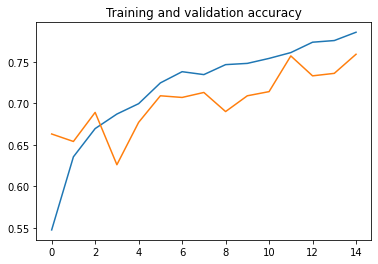

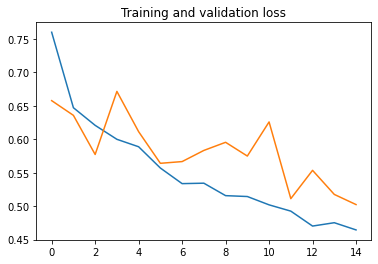

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
os.listdir("../content/drive/My Drive")

['Getting started.pdf',
 'plant-pathology-2020-fgvc7',
 'monk_v1',
 'model.pt',
 'model1.pt',
 'model_keras.h5',
 'model.h5',
 'Quantised_model.h5',
 'model01.pt',
 'Quantised_model01.pt',
 'model_quantized_and_trained.pt',
 'modelVGG16.pt',
 'model_quantized_and_trainedVGG16.pt',
 'keras_final.h5',
 'tflite_models',
 'keras_final1.h5']

In [ ]:
model.save("../content/drive/My Drive/keras_final1.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("../content/drive/My Drive/keras_final1.h5")

In [ ]:
import time
start = time.process_time()
score = model.evaluate_generator(validation_generator, 50)
print(time.process_time()-start)
print(score)

22.866989283000002
[0.5108731943368912, 0.751]


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

In [ ]:
import numpy as np
for i in validation_generator:
  print(np.shape(i[0]))
  imag = i[0]
  break

  

(20, 150, 150, 3)


In [ ]:
print(np.shape(imag))

(20, 150, 150, 3)


In [ ]:
images = tf.cast(imag, tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
def representative_data_gen():
  for input_value in mnist_ds.take(100):
    yield [input_value]

converter.representative_dataset = representative_data_gen

In [ ]:
import pathlib
tflite_models_dir = pathlib.Path("../content/drive/My Drive/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"keras_model.tflite"
tflite_model_file.write_bytes(tflite_model)

37981092

In [ ]:
tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"keras_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

9502936

In [ ]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"keras_model_quant_io.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

9502936

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()
input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

In [ ]:
for i in validation_generator[0]:
  print(i.shape)
  x = i
  break
for i in validation_generator[0]:
  y = i
print(y.shape)

(20, 150, 150, 3)
(20,)


In [ ]:
j = 0
for i,k in validation_generator:
  print(i.shape)
  print(k)
  break


(20, 150, 150, 3)
[1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]


(150, 150, 3)


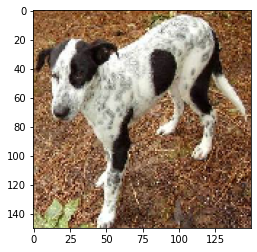

In [ ]:
imgs = x[1]
import matplotlib.pyplot as plt
print(imgs.shape)
plt.imshow(imgs)

In [ ]:
test_image = np.expand_dims(imgs, axis=0).astype(np.float32)
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.allocate_tensors()
interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)
print(predictions)

[[0.9585712]]


In [ ]:
input_index = interpreter_quant.get_input_details()[0]["index"]
output_index = interpreter_quant.get_output_details()[0]["index"]
interpreter_quant.set_tensor(input_index, test_image)
interpreter_quant.allocate_tensors()
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(output_index)

In [ ]:
print(predictions)

[[0.00390625]]


In [ ]:
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  accurate_count = 0
  total = 0
  count = 0
  for i,k in validation_generator:
    count +=1
    if(count == 50):
      return(accurate_count/total)
    prediction_digits = []
    for test_image in i:
      # Pre-processing: add batch dimension and convert to float32 to match with
      # the model's input data format.
      test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
      interpreter.set_tensor(input_index, test_image)

      # Run inference.
      interpreter.allocate_tensors()
      interpreter.invoke()

      # Post-processing: remove batch dimension and find the digit with highest
      # probability.
      output = interpreter.get_tensor(output_index)
      if(output[0][0] <= 0.5):
        digit = 0
      else:
        digit = 1
      prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy.
    for j in range(len(k)):
      if prediction_digits[j] == k[j]:
        accurate_count += 1
      total +=1

In [ ]:
start = time.process_time()
print(evaluate_model(interpreter))
print("time taken ==>" ,time.process_time() - start)

0.7540816326530613
time taken ==> 20.881205223000002


In [ ]:
start = time.process_time()
print(evaluate_model(interpreter_quant))
print("time taken ==>" ,time.process_time() - start)

0.49387755102040815
time taken ==> 233.92854881300002
